# implementation

In [91]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import v_measure_score

In [92]:
class kohonen:

    def __init__(self, M, N, X, learning_rate=0.1):
        self.M = M
        self.N = N
        self.learning_rate = learning_rate
        self.input_dim = X.shape[1]
        minimum = np.min(X, axis=0)
        maximum = np.max(X, axis=0)
        self.weights = np.random.uniform(0, 1, (self.input_dim, M, N))
        for i in range(self.input_dim):
            self.weights[i] = minimum[i] + (maximum[i] - minimum[i]) * self.weights[i]

    def gauss_neighborhood(self, t, T):
        return np.exp(-t * T)

    # def mexican_hat_neighborhood(self, t, T):
    #     return np.exp(-t / T) * (1 - 2 * t / T)

    def euclidean_distance(self, x, y):
        return np.linalg.norm(x - y)

    def slow_down(self, t, iteration_num):
        return self.learning_rate * np.exp(-t / iteration_num)

    def train(self, X, max_epochs):
        for epoch in range(max_epochs):
            X = np.random.permutation(X)
            for x in X:
                bmu = None
                bmu_distance = np.inf
                for i in range(self.M):
                    for j in range(self.N):
                        distance = self.euclidean_distance(x, self.weights[:, i, j])
                        if distance < bmu_distance:
                            bmu_distance = distance
                            bmu = (i, j)

                for i in range(self.M):
                    for j in range(self.N):
                        distance = self.euclidean_distance(
                            np.array(bmu), np.array([i, j])
                        )
                        self.weights[:, i, j] += (
                            self.slow_down(epoch, max_epochs)
                            * self.gauss_neighborhood(distance, epoch)
                            * (x - self.weights[:, i, j])
                        )

    def predict(self, X):
        return np.array(
            [
                [
                    np.argmin(
                        [
                            self.euclidean_distance(x, self.weights[:, i, j])
                            for i in range(self.M)
                            for j in range(self.N)
                        ]
                    )
                    for x in X
                ]
            ]
        ).T

In [93]:
X = pd.DataFrame(np.random.uniform(-1, 4, (10, 2)), columns=["x", "y"]).to_numpy()

In [94]:
koch = kohonen(10, 10, X)

Text(0, 0.5, 'y')

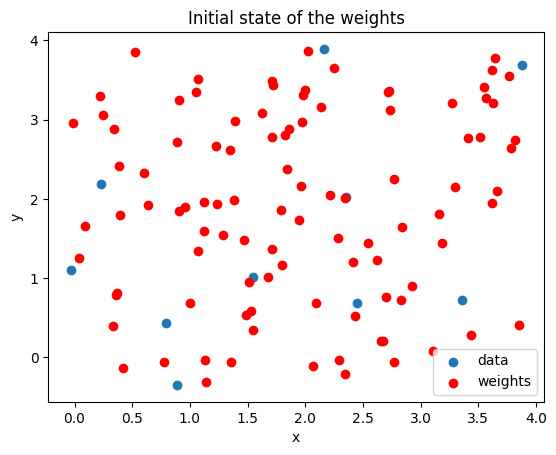

In [95]:
# plot scater plot of x
plt.scatter(X[:, 0], X[:, 1], label="data")
plt.scatter(koch.weights[0], koch.weights[1], c="red", label="weights")
plt.legend()
plt.title("Initial state of the weights")
plt.xlabel("x")
plt.ylabel("y")

In [96]:
cube = pd.read_csv("./../data/kohonen/cube.csv")

In [97]:
cube

,x,y,z,c
0,0.187781,0.239537,0.382492,0
1,-1.308979,-0.143321,-0.966648,0
2,-0.987613,0.679918,-0.037552,0
3,0.924980,0.607235,-0.146856,0
4,-0.098663,0.004329,-0.588876,0
...,...,...,...,...
1195,2.740583,3.037202,2.723101,7
1196,2.303258,4.337946,2.798172,7
1197,3.528407,4.575523,1.406155,7
1198,2.236023,3.901189,1.529630,7


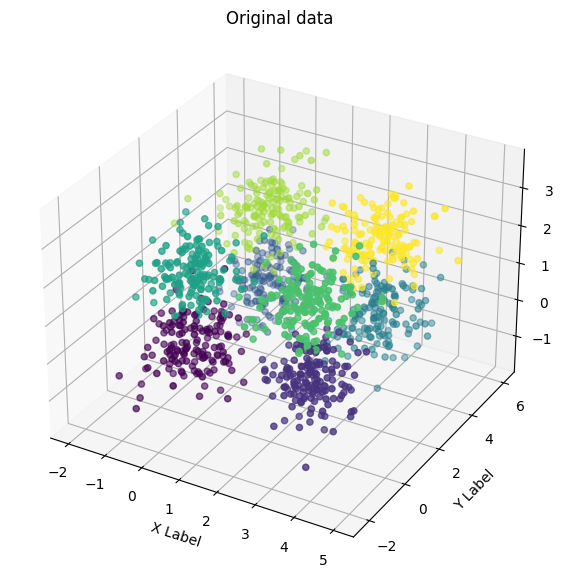

In [98]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(projection="3d")
ax.scatter(cube["x"], cube["y"], cube["z"], c=cube["c"])
ax.set_xlabel("X Label")
ax.set_ylabel("Y Label")
ax.set_zlabel("Z Label")
ax.title.set_text("Original data")

In [114]:
cube_x = cube.drop("c", axis=1).to_numpy()
kohon = kohonen(2, 4, cube_x)
print(kohon.weights)

[[[ 3.09765681  2.76089565  4.71799001  2.16240263]
  [-1.02246035  2.95308147  3.90264918  1.98511629]]

 [[ 5.56505317  4.35571317  0.88044798  0.99228359]
  [ 5.61359829  4.75376209  0.03347701  2.23340854]]

 [[ 0.89747791  3.04928147  3.56984206  1.54602232]
  [ 1.12035104  2.49059774  1.53613712 -0.568748  ]]

 [[ 1.90770246  1.47471184  1.9175739   5.81029553]
  [ 2.1709781   4.36836923  1.6172008   5.68149151]]]


In [115]:
kohon.train(cube_x, 10)
cube["predicted"] = kohon.predict(cube_x)
cube

,x,y,z,c,predicted
0,0.187781,0.239537,0.382492,0,6
1,-1.308979,-0.143321,-0.966648,0,6
2,-0.987613,0.679918,-0.037552,0,6
3,0.924980,0.607235,-0.146856,0,6
4,-0.098663,0.004329,-0.588876,0,6
...,...,...,...,...,...
1195,2.740583,3.037202,2.723101,7,4
1196,2.303258,4.337946,2.798172,7,4
1197,3.528407,4.575523,1.406155,7,4
1198,2.236023,3.901189,1.529630,7,4


In [116]:
v_measure_score(cube["c"], cube["predicted"])

0.9154386507306028

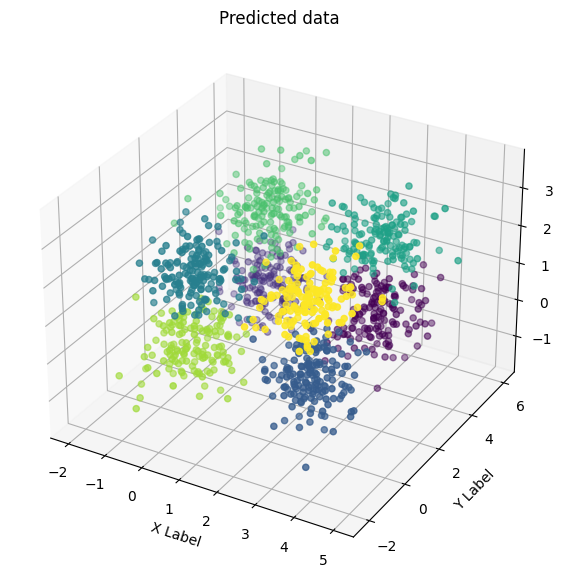

In [117]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(projection="3d")
ax.scatter(cube["x"], cube["y"], cube["z"], c=cube["predicted"])
ax.set_xlabel("X Label")
ax.set_ylabel("Y Label")
ax.set_zlabel("Z Label")
ax.title.set_text("Predicted data")

In [120]:
from sklearn.metrics.cluster import contingency_matrix

a = contingency_matrix(cube["c"], cube["predicted"])
a

array([[  0,   0,   0,   7,   0,   0, 143,   0],
       [  0,   0, 149,   0,   0,   0,   0,   1],
       [  1, 144,   0,   0,   0,   5,   0,   0],
       [143,   1,   0,   0,   6,   0,   0,   0],
       [  0,   0,   0, 147,   0,   0,   3,   0],
       [  0,   0,   7,   2,   0,   0,   0, 141],
       [  0,   5,   0,   0,   0, 145,   0,   0],
       [ 12,   0,   0,   0, 138,   0,   0,   0]])

In [125]:
mapper = np.argmax(a, axis=1)
ma = {mapper[i]: i for i in range(len(mapper))}
cube["predicted_remapped"] = [ma[i] for i in cube["predicted"]]
cube["right"] = cube["c"] == cube["predicted_remapped"]
cube["color"] = ["green" if i else "red" for i in cube["right"]]
cube

,x,y,z,c,predicted,predicted_remapped,right,color
0,0.187781,0.239537,0.382492,0,6,0,True,green
1,-1.308979,-0.143321,-0.966648,0,6,0,True,green
2,-0.987613,0.679918,-0.037552,0,6,0,True,green
3,0.924980,0.607235,-0.146856,0,6,0,True,green
4,-0.098663,0.004329,-0.588876,0,6,0,True,green
...,...,...,...,...,...,...,...,...
1195,2.740583,3.037202,2.723101,7,4,7,True,green
1196,2.303258,4.337946,2.798172,7,4,7,True,green
1197,3.528407,4.575523,1.406155,7,4,7,True,green
1198,2.236023,3.901189,1.529630,7,4,7,True,green


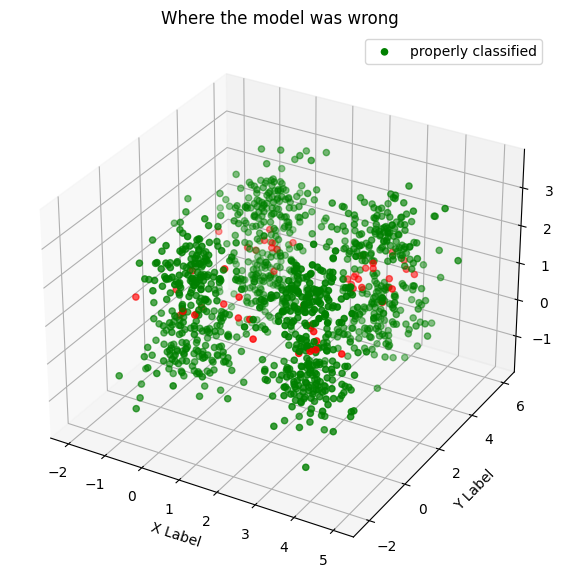

In [133]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(projection="3d")
ax.scatter(cube["x"], cube["y"], cube["z"], c=cube["color"])
ax.set_xlabel("X Label")
ax.set_ylabel("Y Label")
ax.set_zlabel("Z Label")
ax.title.set_text("Where the model was wrong")
plt.legend(["properly classified"])